In [1]:
import pandas as pd
import mysql.connector
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

In [2]:
# !pip install pymssql pandas imbalanced-learn scikit-learn

In [3]:

# Connect to SQL Server
conn = mysql.connector.connect(host="localhost", user="root", password="root", database="GooglePlayStore")

# Fetch Data
query = "SELECT * FROM rating"
df = pd.read_sql(query, conn)

# Close connection
conn.close()

df = df.drop('id', axis=1)
# Show first few rows
print(df.head())



C:\Users\shree\AppData\Local\Temp\ipykernel_2836\268454948.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   Category  Rating_Count  Installs  Free  Size_in_Mb  Content_Rating  \
0   2.24681         262.0   10000.0     1    4.200000         2.18234   
1   2.70581           8.0      10.0     1   36.000000         2.18234   
2   2.45978        2352.0  500000.0     1   26.000000         2.18234   
3   1.93159          70.0   10000.0     1    0.097656         2.18234   
4   1.93159           0.0      10.0     1    2.900000         2.18234   

   Ad_Supported  In_App_Purchases  Editors_Choice  Transformed_Rating  
0             0                 1               0                   5  
1             1                 0               0                   5  
2             0                 0               0                   3  
3             0                 0               0                   3  
4             0                 0               0                   0  


In [4]:
df.Transformed_Rating.value_counts()

Transformed_Rating
0    92553
4    50957
5    36943
3    15689
2     3489
1      369
Name: count, dtype: int64

## Feature Extraction

In [5]:
df.shape

(200000, 10)

In [16]:

from imblearn.over_sampling import SMOTE
from collections import Counter

# Define target column
target_col = "Transformed_Rating"
X = df.drop(columns=[target_col])
y = df[target_col]

# Apply SMOTE
# smote = SMOTE(sampling_strategy="auto", random_state=7)
# X_resampled, y_resampled = smote.fit_resample(X, y)


# from imblearn.over_sampling import ADASYN
# adasyn = ADASYN(random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(X, y)

# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

######################
from imblearn.over_sampling import SMOTENC
# Specify categorical feature indices (column positions)
categorical_features = [0, 2]  # Adjust as per dataset
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=7)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)


# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=7)


# Train Decision Tree and Calculate Feature Importance
dt = DecisionTreeClassifier(random_state=7)
dt.fit(X_train, Y_train)

# Mean importance threshold
mean_imp = dt.feature_importances_.mean()
selected_features = X_train.columns[dt.feature_importances_ > mean_imp]
print("Selected Features Based on Decision Tree Importance:")
print(selected_features)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=DecisionTreeClassifier(random_state=7))
rfe.fit(X_train, Y_train)

# Print feature rankings
print("\nRFE Feature Rankings:")
for rank, feature in sorted(zip(rfe.ranking_, X_train.columns)):
    print(f"{feature}: {rank}")

Selected Features Based on Decision Tree Importance:
Index(['Category', 'Rating_Count', 'Size_in_Mb'], dtype='object')

RFE Feature Rankings:
Category: 1
Content_Rating: 1
Rating_Count: 1
Size_in_Mb: 1
Installs: 2
Ad_Supported: 3
In_App_Purchases: 4
Free: 5
Editors_Choice: 6


In [17]:
# Feature and Target
X = df.drop('Transformed_Rating', axis=1)
Y = df['Transformed_Rating'].astype(int)  # Ensure categorical target

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7, stratify=Y)

# Train Decision Tree and Calculate Feature Importance
dt = DecisionTreeClassifier(random_state=7)
dt.fit(X_train, Y_train)

# Mean importance threshold
mean_imp = dt.feature_importances_.mean()
selected_features = X_train.columns[dt.feature_importances_ > mean_imp]
print("Selected Features Based on Decision Tree Importance:")
print(selected_features)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=DecisionTreeClassifier(random_state=7))
rfe.fit(X_train, Y_train)

# Print feature rankings
print("\nRFE Feature Rankings:")
for rank, feature in sorted(zip(rfe.ranking_, X_train.columns)):
    print(f"{feature}: {rank}")


Selected Features Based on Decision Tree Importance:
Index(['Rating_Count', 'Size_in_Mb'], dtype='object')

RFE Feature Rankings:
Category: 1
Content_Rating: 1
Rating_Count: 1
Size_in_Mb: 1
Installs: 2
In_App_Purchases: 3
Ad_Supported: 4
Free: 5
Editors_Choice: 6


In [18]:
target_col = "Transformed_Rating"
class_counts = df["Transformed_Rating"].value_counts()

# Print class distribution
print("Class Distribution:")
print(class_counts)

Class Distribution:
Transformed_Rating
0    92553
4    50957
5    36943
3    15689
2     3489
1      369
Name: count, dtype: int64


In [21]:
import pandas as pd

# Assuming you have a pandas DataFrame df with a target column 'target'
# Replace 'target' with the actual column name of your target variable
target_column = 'Transformed_Rating'

# Check the distribution of the target variable
class_counts = df[target_column].value_counts()

# Print the distribution
print(class_counts)

# Check if the data is imbalanced
# If the difference in class counts is large, it's likely imbalanced
if class_counts.min() / class_counts.max() < 0.2:  # This is just an example threshold
    print("The data is imbalanced.")
else:
    print("The data is balanced.")


Transformed_Rating
0    92553
4    50957
5    36943
3    15689
2     3489
1      369
Name: count, dtype: int64
The data is imbalanced.


In [25]:
# from imblearn.over_sampling import SMOTE
# import pandas as pd

# # Assuming your target column is 'target' and features are in 'X', with 'y' as the target
# X = df.drop(columns=['Transformed_Rating'])  # Your feature matrix
# y = df['Transformed_Rating']  # Your target variable

# # Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X, y)

# from imblearn.under_sampling import RandomUnderSampler

# # Assuming your target column is 'target' and features are in 'X', with 'y' as the target
# X = df.drop(columns=['Transformed_Rating'])  # Your feature matrix
# y = df['Transformed_Rating']  # Your target variable

# # Apply Random Undersampling to balance the dataset
# under_sampler = RandomUnderSampler(random_state=42)
# X_res, y_res = under_sampler.fit_resample(X, y)

# # Check the new class distribution
# print(pd.Series(y_res).value_counts())





from sklearn.model_selection import StratifiedKFold

# Create stratified k-fold
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Check the new class distribution
print(pd.Series(y_res).value_counts())
if class_counts.min() / class_counts.max() < 0.2:  # This is just an example threshold
    print("The data is imbalanced.")
else:
    print("The data is balanced.")


Transformed_Rating
0    369
1    369
2    369
3    369
4    369
5    369
Name: count, dtype: int64
The data is imbalanced.


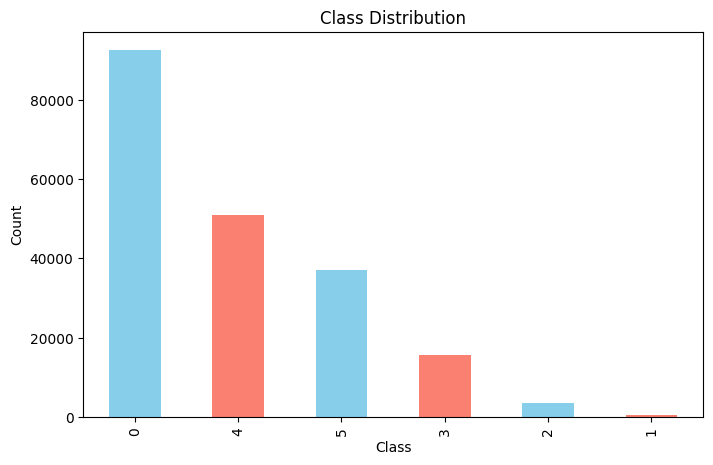

In [26]:

# Visualizing the class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [27]:
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Imbalance Ratio: 0.00


In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, random_state=7)
hgbc.fit(X_train, Y_train)
y_pred = hgbc.predict(X_test)
hgbc_ac = accuracy_score(Y_test, y_pred)

print("HistGradientBoosting Classifier Accuracy:", hgbc_ac)

ValueError: Found input variables with inconsistent numbers of samples: [160000, 140000]

In [ ]:
#Applying Model Logistic Regression

logreg_c=LogisticRegression(max_iter=500, random_state=7, class_weight='balanced')
logreg_c.fit(X_train,Y_train)
logreg_pred=logreg_c.predict(X_test)
logreg_cm=confusion_matrix(Y_test,logreg_pred)
logreg_ac=accuracy_score(Y_test, logreg_pred)
print('LogisticRegression_accuracy:',logreg_ac)

In [ ]:
#Applying Model RandomForest

rdf_c=RandomForestClassifier(random_state=7)
rdf_c.fit(X_train,Y_train)
rdf_pred=rdf_c.predict(X_test)
rdf_cm=confusion_matrix(Y_test,rdf_pred)
rdf_ac=accuracy_score(rdf_pred,Y_test)
print('RandomForest_Accuracy: ', rdf_ac)

In [ ]:
#Applying Model DecisionTree Classifier

dtree_c=DecisionTreeClassifier(random_state=7,criterion='entropy', max_depth = 10, min_samples_leaf = 2, min_samples_split = 5)
dtree_c.fit(X_train,Y_train)
dtree_pred=dtree_c.predict(X_test)
dtree_cm=confusion_matrix(Y_test,dtree_pred)
dtree_ac=accuracy_score(dtree_pred,Y_test)
print('DecisionTreeClassifier_Accuracy: ',dtree_ac)

In [ ]:
#Applying Model Naive Bayesian

NB = BernoulliNB(binarize = 0.0)
NB.fit(X_train,Y_train)
y_pred = NB.predict(X_test)
nb_ac=accuracy_score(Y_test, y_pred)
print("Bernoulli Naive Bayes_Accuracy: ", nb_ac)

In [ ]:
# Fine-tuning K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, Y_train)

# Best parameters and score for KNN
print("Best Parameters (KNN):", grid_search_knn.best_params_)
print("Best Accuracy (KNN):", grid_search_knn.best_score_)

In [ ]:
# Applying K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
knn_ac = accuracy_score(Y_test, y_pred)

print("K-Nearest Neighbors Accuracy:", knn_ac)


In [ ]:
# Fine-tuning Linear Discriminant Analysis (LDA)
from sklearn.model_selection import GridSearchCV

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen']
}

lda = LinearDiscriminantAnalysis()
grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lda.fit(X_train, Y_train)

# Best parameters and score for LDA
print("Best Parameters (LDA):", grid_search_lda.best_params_)
print("Best Accuracy (LDA):", grid_search_lda.best_score_)

In [ ]:
# Applying Linear Discriminant Analysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
y_pred = lda.predict(X_test)
lda_ac = accuracy_score(Y_test, y_pred)

print("Linear Discriminant Analysis Accuracy:", lda_ac)


In [ ]:
# Applying Gradient Boosting Classifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=7)
gbc.fit(X_train, Y_train)
y_pred = gbc.predict(X_test)
gbc_ac = accuracy_score(Y_test, y_pred)

print("Gradient Boosting Classifier Accuracy:", gbc_ac)


In [ ]:
# Applying AdaBoost Classifier

abc = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=7)
abc.fit(X_train, Y_train)
y_pred = abc.predict(X_test)
abc_ac = accuracy_score(Y_test, y_pred)

print("AdaBoost Classifier Accuracy:", abc_ac)


In [ ]:
# Fine-tuning XGBoost Classifier
# !pip install --upgrade xgboost scikit-learn

from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=7)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, Y_train)

# Best parameters and score for XGBoost
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Best Accuracy (XGBoost):", grid_search_xgb.best_score_)


In [ ]:
# Applying XGBoost Classifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=7, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, Y_train)
y_pred = xgb.predict(X_test)
xgb_ac = accuracy_score(Y_test, y_pred)

print("XGBoost Classifier Accuracy:", xgb_ac)


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model
hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, Y_train)

# Predict on test set
y_pred = hgb.predict(X_test)

# Calculate accuracy
hgb_ac = accuracy_score(Y_test, y_pred)
print("HistGradientBoostingClassifier Accuracy:", hgb_ac)


In [ ]:
# Fine-tuning CatBoost Classifier
param_grid_catboost = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}

catboost = CatBoostClassifier(verbose=0)
grid_search_catboost = GridSearchCV(catboost, param_grid_catboost, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_catboost.fit(X_train, y_train)

# Best parameters and score for CatBoost
print("Best Parameters (CatBoost):", grid_search_catboost.best_params_)
print("Best Accuracy (CatBoost):", grid_search_catboost.best_score_)

In [ ]:
#Applying Model CatBoost Model

Cat_Boost = CatBoostClassifier(verbose = 0, n_estimators = 100)
Cat_Boost.fit(X_train, Y_train)
cb_ac=Cat_Boost.score(X_train, Y_train)
print("CatBoost_Accuracy: ",cb_ac)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

import pandas as pd
import mysql.connector

# Load CSV into Pandas
df = pd.read_csv(r"C:\Users\shree\Downloads\Playstore\sampled_file_processed_final.csv")

# Connect to MySQL
conn = mysql.connector.connect(host="localhost", user="root", password="root", database="GooglePlayStore")
cursor = conn.cursor()

# Insert data row by row
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO rating (Category, Rating_Count, Installs, Free, Size_in_Mb, Content_Rating, Ad_Supported, In_App_Purchases, Editors_Choice, Transformed_Rating)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, tuple(row))

# Commit and close
conn.commit()
cursor.close()
conn.close()

print("CSV uploaded successfully!")

df.info()
df.shape

df.columns

df.isnull().sum()

missing_percentage = (df.isnull().sum().sort_values(ascending = False)/len(df))*100
missing_percentage

#Dropping unnecessary columns
df=df.drop(columns=['App Name','App Id','Price','Currency','Minimum Installs','Maximum Installs','Developer Id','Developer Website','Minimum Android','Developer Email','Released','Last Updated','Privacy Policy','Scraped Time'])

df['Category'].unique()

df['Rating'].unique()

df['Content Rating'].value_counts()

df['Editors Choice'].unique()

df.info()

# # Calculate counts for exact values (e.g., 1.5, 2.5, etc.)
counts = df['Rating'].value_counts()
counts_dict = counts.to_dict()

# Define a helper function to handle exact values (e.g., 1.5, 2.5, etc.)
def handle_exact_rating(rating):
    if rating in [1.5, 2.5, 3.5, 4.5]:  # Add more exact values if needed
        higher_rating = round(rating + 0.1, 1)

        higher_count = counts_dict.get(higher_rating, 0)
        rating_count = counts_dict.get(rating, 0)

        if rating < higher_count:
            return int(rating)  # Round down
        else:
            return int(rating) + 1  # Round up
    return None

# Function to transform the Rating column
def transform_rating(rating):
    if pd.isnull(rating):
        return np.nan
    
    if rating == 0:
        return 0
    elif 1 <= rating < 1.5:
        return 1
    elif 1.5 <= rating < 2.5:
        return handle_exact_rating(1.5) if rating == 1.5 else 2
    elif 2.5 <= rating < 3.5:
        return handle_exact_rating(2.5) if rating == 2.5 else 3
    elif 3.5 <= rating < 4.5:
        return handle_exact_rating(3.5) if rating == 3.5 else 4
    else:
        return 5


# Apply the transformation to the dataframe
df['Transformed_Rating'] = df['Rating'].apply(transform_rating)

df.drop('Rating',axis=1,inplace=True)


# Display the transformed dataframe
df

# Calculate the mean 'Rating' for each 'Category'
category_means = df.groupby("Category")["Transformed_Rating"].mean()

# Fill null or blank values in the 'Rating' column with the category-wise mean
df["Transformed_Rating"] = df.apply(
    lambda row: category_means[row["Category"]] if pd.isnull(row["Transformed_Rating"]) else row["Transformed_Rating"],
    axis=1
)

df.isnull().sum()

df['Size'].unique()

def convert_to_mb(size):
    if isinstance(size, str):
        # Remove commas from the string
        size = size.replace(',', '')

        if 'k' in size:
            # Remove 'k' and convert to MB (1 MB = 1024 KB)
            size = float(size.replace('k', '')) / 1024
        elif 'M' in size:
            # Remove 'M' (already in MB)
            size = float(size.replace('M', ''))
        elif 'G' in size:
            # Remove 'G' and convert to MB (1GB = 1024 MB)
            size = float(size.replace('G', '')) * 1024
        elif 'Varies with device' in size:
            return np.nan

    return size

df['Size'] = df['Size'].apply(convert_to_mb)
# Rename the column 'Size' to 'Size_in_Mb'
df.rename(columns={'Size': 'Size_in_Mb'}, inplace=True)

# Repeat the process for Rating
Q1 = df['Size_in_Mb'].quantile(0.25)
Q3 = df['Size_in_Mb'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Size_in_Mb'] < lower_bound) | (df['Size_in_Mb'] > upper_bound)]
print("\nOutliers in Size column:")
print(outliers)

#Replace null values in size column with median category wise 
#As mean values is greater than median and data is +vely skewed hence replacing with median 
df['Size_in_Mb'] = df['Size_in_Mb'].fillna(df.groupby('Category')['Size_in_Mb'].transform('median').round(2))

df.isnull().sum()

# Repeat the process for Rating
Q1_rating_count = df['Rating Count'].quantile(0.25)
Q3_rating_count = df['Rating Count'].quantile(0.75)
IQR = Q3_rating_count - Q1_rating_count

lower_bound = Q1_rating_count - 1.5 * IQR
upper_bound = Q3_rating_count + 1.5 * IQR
outliers = df[(df['Size_in_Mb'] < lower_bound) | (df['Size_in_Mb'] > upper_bound)]
print("\nOutliers in Size column:")
outliers

df['Rating Count'] = df['Rating Count'].fillna(df.groupby('Category')['Rating Count'].transform('mean').round(2))

df.isnull().sum()

from sklearn.model_selection import KFold

def k_fold_target_encoding(data, category_col, target_col, n_splits=5, smoothing=1):
    global_mean = data[target_col].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded_col = pd.Series(np.zeros(data.shape[0]), index=data.index)

    for train_idx, val_idx in kf.split(data):
        train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]
        
        # Calculate category statistics on the training fold
        category_stats = train_data.groupby(category_col)[target_col].agg(['mean', 'count'])
        category_stats['smoothed'] = (category_stats['count'] * category_stats['mean'] + 
                                      smoothing * global_mean) / (category_stats['count'] + smoothing)
        
        # Map smoothed statistics to validation fold
        val_data_encoded = val_data[category_col].map(category_stats['smoothed']).fillna(global_mean)
        encoded_col.iloc[val_idx] = val_data_encoded

    return encoded_col

# Apply K-Fold Target Encoding and replace the original column
df['Category'] = k_fold_target_encoding(df, category_col='Category', target_col='Transformed_Rating')

# Apply K-Fold Target Encoding to 'Content Rating' column
df['Content Rating'] = k_fold_target_encoding(df, category_col='Content Rating', target_col='Transformed_Rating')

# Verify the result
print(df.head())


df.columns

#Cleaning Installs Column(remove , and + and convert the data type from object to float)
df['Installs'] = df['Installs'].str.replace(',','').str.replace('+','').astype('float')

df.shape

df.head()

# df_ohe = pd.get_dummies(df, columns=['Content Rating'])

df.info()

df.head()

# boolean columns to 0 and 1
bool_cols = ['Free', 'Ad Supported', 'In App Purchases','Editors Choice']
df[bool_cols] = df[bool_cols].astype(int)

df.head()

df['Installs'] = df.groupby('Category')['Installs'].transform(lambda x: x.fillna(x.mean()))

df.head()

df_sampled = df.sample(n=200000, random_state=42)
df_sampled.to_csv("sampled_file_processed_final.csv", index=False)

## Feature Extraction

# Feature and Target
X = df.drop('Transformed_Rating', axis=1)
Y = df['Transformed_Rating'].astype(int)  # Ensure categorical target

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7, stratify=Y)

# Train Decision Tree and Calculate Feature Importance
dt = DecisionTreeClassifier(random_state=7)
dt.fit(X_train, Y_train)

# Mean importance threshold
mean_imp = dt.feature_importances_.mean()
selected_features = X_train.columns[dt.feature_importances_ > mean_imp]
print("Selected Features Based on Decision Tree Importance:")
print(selected_features)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=DecisionTreeClassifier(random_state=7))
rfe.fit(X_train, Y_train)

# Print feature rankings
print("\nRFE Feature Rankings:")
for rank, feature in sorted(zip(rfe.ranking_, X_train.columns)):
    print(f"{feature}: {rank}")


#Applying Model Logistic Regression

logreg_c=LogisticRegression(max_iter=500, random_state=7, class_weight='balanced')
logreg_c.fit(X_train,Y_train)
logreg_pred=logreg_c.predict(X_test)
logreg_cm=confusion_matrix(Y_test,logreg_pred)
logreg_ac=accuracy_score(Y_test, logreg_pred)
print('LogisticRegression_accuracy:',logreg_ac)

#Applying Model RandomForest

rdf_c=RandomForestClassifier(random_state=7)
rdf_c.fit(X_train,Y_train)
rdf_pred=rdf_c.predict(X_test)
rdf_cm=confusion_matrix(Y_test,rdf_pred)
rdf_ac=accuracy_score(rdf_pred,Y_test)
print('RandomForest_Accuracy: ', rdf_ac)

# Fine-tuning Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree = DecisionTreeClassifier(random_state=7)
grid_search_dtree = GridSearchCV(dtree, param_grid_dtree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dtree.fit(X_train, Y_train)

# Best parameters and score for Decision Tree
print("Best Parameters (Decision Tree):", grid_search_dtree.best_params_)
print("Best Accuracy (Decision Tree):", grid_search_dtree.best_score_)

#Applying Model DecisionTree Classifier

dtree_c=DecisionTreeClassifier(random_state=7,)
dtree_c.fit(X_train,Y_train)
dtree_pred=dtree_c.predict(X_test)
dtree_cm=confusion_matrix(Y_test,dtree_pred)
dtree_ac=accuracy_score(dtree_pred,Y_test)
print('DecisionTreeClassifier_Accuracy: ',dtree_ac)

#Applying Model Naive Bayesian

NB = BernoulliNB(binarize = 0.0)
NB.fit(X_train,Y_train)
y_pred = NB.predict(X_test)
nb_ac=accuracy_score(Y_test, y_pred)
print("Bernoulli Naive Bayes_Accuracy: ", nb_ac)

# Fine-tuning K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, Y_train)

# Best parameters and score for KNN
print("Best Parameters (KNN):", grid_search_knn.best_params_)
print("Best Accuracy (KNN):", grid_search_knn.best_score_)

# Applying K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
knn_ac = accuracy_score(Y_test, y_pred)

print("K-Nearest Neighbors Accuracy:", knn_ac)


# Fine-tuning Linear Discriminant Analysis (LDA)
from sklearn.model_selection import GridSearchCV

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen']
}

lda = LinearDiscriminantAnalysis()
grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lda.fit(X_train, Y_train)

# Best parameters and score for LDA
print("Best Parameters (LDA):", grid_search_lda.best_params_)
print("Best Accuracy (LDA):", grid_search_lda.best_score_)



# Applying Linear Discriminant Analysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
y_pred = lda.predict(X_test)
lda_ac = accuracy_score(Y_test, y_pred)

print("Linear Discriminant Analysis Accuracy:", lda_ac)


# Applying Gradient Boosting Classifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=7)
gbc.fit(X_train, Y_train)
y_pred = gbc.predict(X_test)
gbc_ac = accuracy_score(Y_test, y_pred)

print("Gradient Boosting Classifier Accuracy:", gbc_ac)


# Applying AdaBoost Classifier

abc = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=7)
abc.fit(X_train, Y_train)
y_pred = abc.predict(X_test)
abc_ac = accuracy_score(Y_test, y_pred)

print("AdaBoost Classifier Accuracy:", abc_ac)


# Fine-tuning XGBoost Classifier
# !pip install --upgrade xgboost scikit-learn

from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=7)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, Y_train)

# Best parameters and score for XGBoost
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Best Accuracy (XGBoost):", grid_search_xgb.best_score_)


# Applying XGBoost Classifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=7, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, Y_train)
y_pred = xgb.predict(X_test)
xgb_ac = accuracy_score(Y_test, y_pred)

print("XGBoost Classifier Accuracy:", xgb_ac)


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model
hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, Y_train)

# Predict on test set
y_pred = hgb.predict(X_test)

# Calculate accuracy
hgb_ac = accuracy_score(Y_test, y_pred)
print("HistGradientBoostingClassifier Accuracy:", hgb_ac)


# Fine-tuning CatBoost Classifier
param_grid_catboost = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}

catboost = CatBoostClassifier(verbose=0)
grid_search_catboost = GridSearchCV(catboost, param_grid_catboost, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_catboost.fit(X_train, y_train)

# Best parameters and score for CatBoost
print("Best Parameters (CatBoost):", grid_search_catboost.best_params_)
print("Best Accuracy (CatBoost):", grid_search_catboost.best_score_)

#Applying Model CatBoost Model

Cat_Boost = CatBoostClassifier(verbose = 0, n_estimators = 100)
Cat_Boost.fit(X_train, Y_train)
cb_ac=Cat_Boost.score(X_train, Y_train)
print("CatBoost_Accuracy: ",cb_ac)



